#### **Event Study - R. v Hydro Quebec**



      AAR  Std. E. AAR       CAAR  Std. E. CAAR  T-stat  P-value
-4 -0.001      0.00342     -0.001       0.00342   -0.16     0.87
-3 -0.004      0.00342     -0.005       0.00483   -1.03     0.30
-2 -0.006      0.00342   -0.011 *       0.00592   -1.94     0.05
-1 -0.004      0.00342  -0.016 **       0.00684   -2.33     0.02
0   0.008      0.00342     -0.008       0.00764   -1.07     0.29
1   0.005      0.00342     -0.003       0.00837   -0.40     0.69
2  -0.004      0.00342     -0.007       0.00904   -0.76     0.45
3   0.001      0.00342     -0.006       0.00967   -0.64     0.52
4  -0.001      0.00342     -0.008       0.01025   -0.75     0.45
5   0.001      0.00342     -0.007       0.01081   -0.63     0.53
6   0.002      0.00342     -0.004       0.01134   -0.40     0.69
7   0.008      0.00342      0.004       0.01184    0.31     0.75
8   0.022      0.00342   0.026 **       0.01232    2.12     0.03


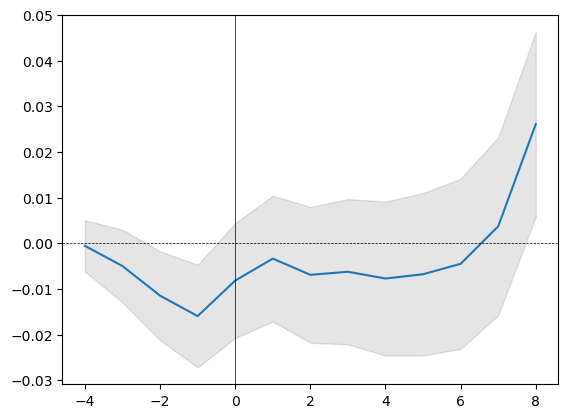

In [50]:
# ---- 0.  Install package once (skip if already installed) ----
# !pip install eventstudy   # uncomment in a fresh environment

# ---- 1.  Imports & data -----------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import eventstudy as es            # package documented in eventstudy.pdf

# (a) security‑level daily returns
RETURNS_CSV = "hydroqc_data.csv"    # <— path to the file the user supplied
es.Single.import_returns(
    RETURNS_CSV,
    is_price=False,                 # the file already contains daily returns
    date_format="%Y-%m-%d"          # first column labelled “date”
)

# (b) Fama–French daily factors
FACTORS_CSV = "factor_data.csv"
es.Single.import_FamaFrench(
    FACTORS_CSV,
    rescale_factor=True,            # factors in %, convert to decimals ÷100
    date_format="%Y-%m-%d"
)

# ---- 2.  Build the list of events --------------------------------------------------------
event_date = np.datetime64("1997-09-18")
tickers = [c for c in pd.read_csv(RETURNS_CSV, nrows=1).columns if c != "date"]

event_list = [{"security_ticker": t, "event_date": event_date} for t in tickers]

# ---- 3.  Aggregate event study -----------------------------------------------------------
hydro_agg = es.Multiple.from_list(
    event_list=event_list,
    event_study_model=es.Single.FamaFrench_5factor,   # 5‑factor model
    event_window=(-4, 8),    # CARs from t = −5 to t = +10
    estimation_size=200,      # pre‑event estimation window length
    buffer_size=30,           # gap between estimation and event windows
    ignore_errors=True        # drop securities with insufficient data
)

# ---- 4.  Output --------------------------------------------------------------------------
# (a) tabular results
print(hydro_agg.results(decimals=[3,5,3,5,2,2]))

# (b) optional visualisation
hydro_agg.plot(confidence=0.95)     # 95 % CI for the CAAR
plt.show()
